In [52]:
import anndata as ad
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats

In [53]:
from dynchro.tl import skip_dtw, skip_traceback

In [54]:
from utils import plot_iroot, comp_kde, kdeplot, kdeplot2, compare, get_kde_eval, norm

In [55]:
import random

random.seed(34)
np.random.seed(34)

In [56]:
d1 = ad.read_h5ad("data/dataseta0_processed.h5ad")
d2 = ad.read_h5ad("data/datasetb0_processed.h5ad")
d2.obs["milestones"] = d2.obs.milestones.cat.rename_categories({'sC': 'sC_batch'})

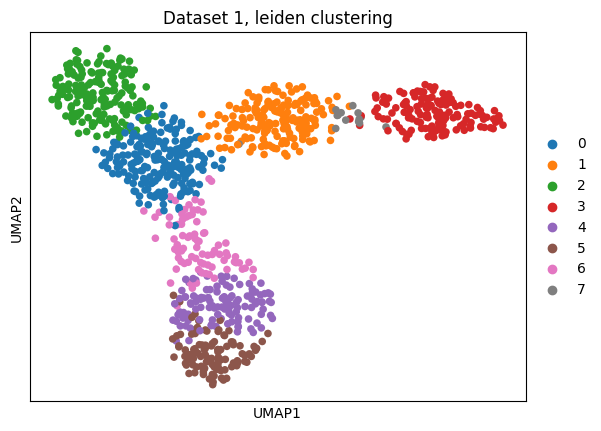

In [58]:
sc.tl.leiden(d1, resolution=1.75, key_added="leiden1.75")
sc.pl.umap(d1, color='leiden1.75', title="Dataset 1, leiden clustering")

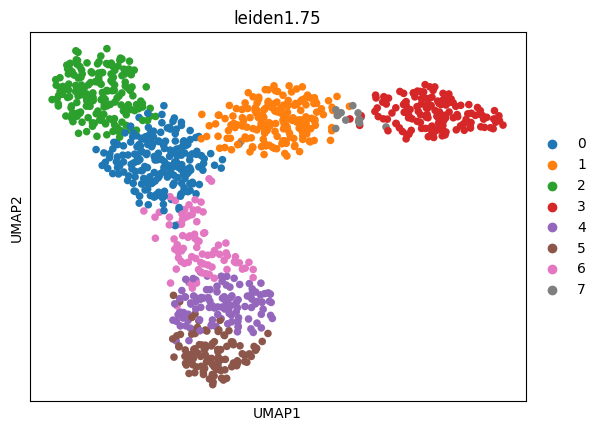

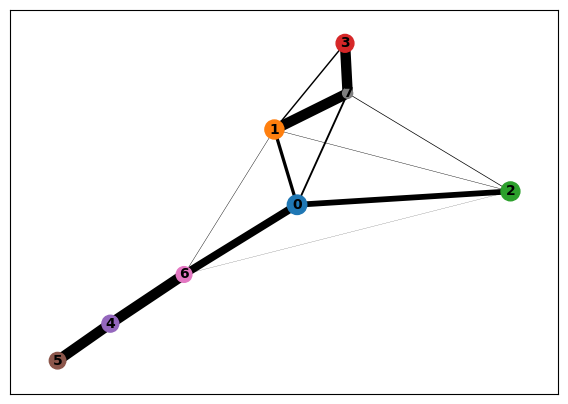

In [59]:
sc.tl.paga(d1, groups="leiden1.75")
sc.pl.umap(d1, color="leiden1.75")
sc.pl.paga(d1)

In [60]:
d1.write_h5ad("data/dynchro1.h5ad")
d2.write_h5ad("data/dynchro2.h5ad")

In [61]:
# select 2, 0, 6, 4, 5 from "leiden1.75"
d1_lin1 = d1[d1.obs["leiden1.75"].isin(["2", "0", "6", "4", "5"])]

# select 2, 0, 1, 7, 3 from "leiden1.75"
d1_lin2 = d1[d1.obs["leiden1.75"].isin(["2", "0", "1", "7", "3"])]

In [62]:
sc.tl.leiden(d2, resolution=1.5, key_added="leiden1.5")

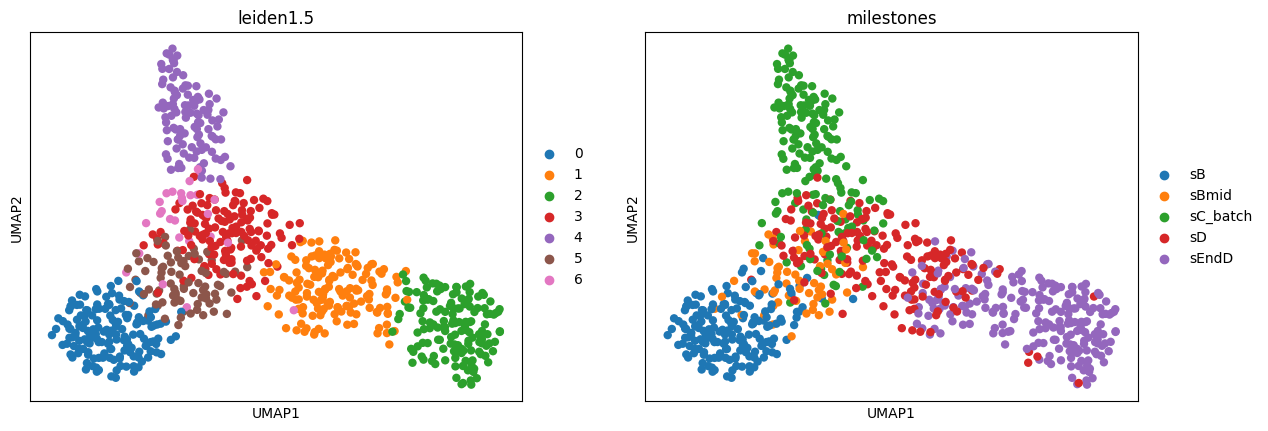

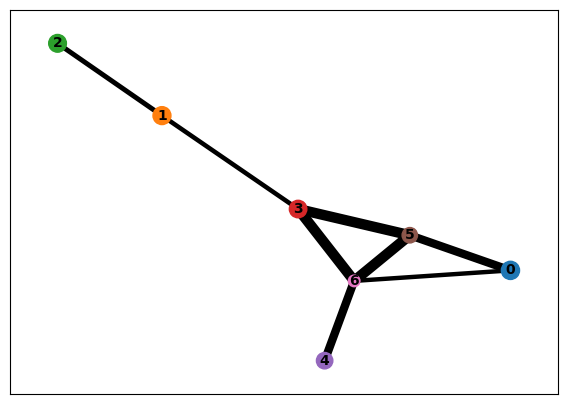

In [63]:
sc.tl.paga(d2, groups="leiden1.5")
sc.pl.umap(d2, color=["leiden1.5", "milestones"])
sc.pl.paga(d2, threshold=0.4)

In [64]:
d1_ss = ad.read_h5ad("data/dynchro1_slingshot.h5ad")
d2_ss = ad.read_h5ad("data/dynchro2_slingshot.h5ad")

In [14]:
d1_ss.X = d1_ss.layers["counts"]
d2_ss.X = d2_ss.layers["counts"]


In [15]:
d1_ss.layers

Layers with keys: counts, counts_protein, counts_spliced, counts_unspliced, logcounts

/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/matplotlib/colors.py:2294: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin


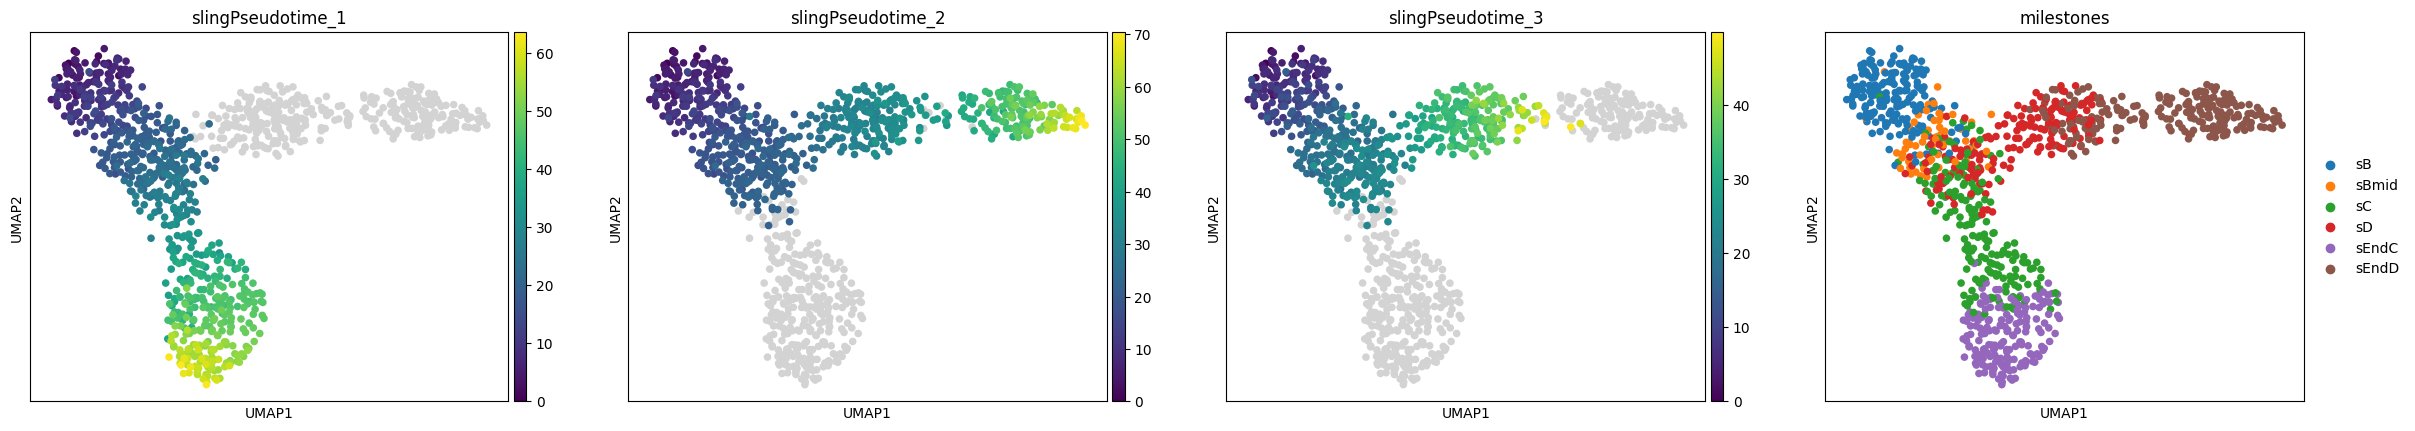

/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/matplotlib/colors.py:2294: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin


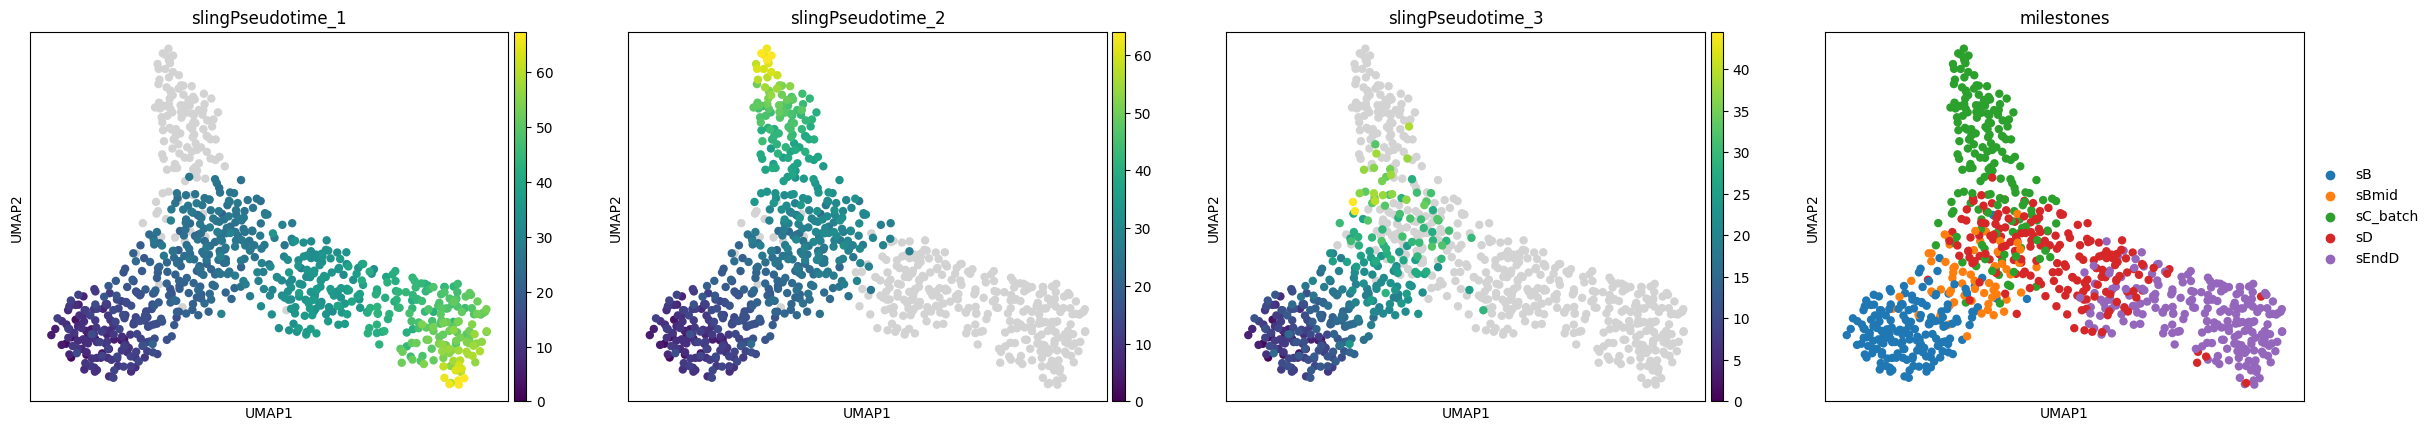

In [16]:
sc.pl.umap(d1_ss, color = ["slingPseudotime_1", "slingPseudotime_2", "slingPseudotime_3", "milestones"])
sc.pl.umap(d2_ss, color = ["slingPseudotime_1", "slingPseudotime_2", "slingPseudotime_3", "milestones"])

In [17]:
d1_lin1 = d1_ss[~d1_ss.obs.slingPseudotime_1.isna()]
d1_lin2 = d1_ss[~d1_ss.obs.slingPseudotime_2.isna()]
d2_lin2 = d2_ss[~d2_ss.obs.slingPseudotime_1.isna()]
d2_lin1 = d2_ss[~d2_ss.obs.slingPseudotime_2.isna()]

In [18]:
d1_lin1.obs["pseudotime"] = d1_lin1.obs.slingPseudotime_1
d1_lin2.obs["pseudotime"] = d1_lin2.obs.slingPseudotime_2
d2_lin1.obs["pseudotime"] = d2_lin1.obs.slingPseudotime_2
d2_lin2.obs["pseudotime"] = d2_lin2.obs.slingPseudotime_1

/tmp/ipykernel_22793/3494121903.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  d1_lin1.obs["pseudotime"] = d1_lin1.obs.slingPseudotime_1
/tmp/ipykernel_22793/3494121903.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  d1_lin2.obs["pseudotime"] = d1_lin2.obs.slingPseudotime_2
/tmp/ipykernel_22793/3494121903.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  d2_lin1.obs["pseudotime"] = d2_lin1.obs.slingPseudotime_2
/tmp/ipykernel_22793/3494121903.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  d2_lin2.obs["pseudotime"] = d2_lin2.obs.slingPseudotime_1


In [19]:
d1_lin1.X

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 143393 stored elements and shape (668, 531)>

### get counts and sort

In [20]:
counts_d1lC = d1_lin1.X.toarray()
counts_d1lD = d1_lin2.X.toarray()
counts_d2lC = d2_lin1.X.toarray()
counts_d2lD = d2_lin2.X.toarray()

In [21]:
sortd1lC = d1_lin1[np.argsort(d1_lin1.obs["pseudotime"]), :]
sortd1lD = d1_lin2[np.argsort(d1_lin2.obs["pseudotime"]), :]
sortd2lC = d2_lin1[np.argsort(d2_lin1.obs["pseudotime"]), :]
sortd2lD = d2_lin2[np.argsort(d2_lin2.obs["pseudotime"]), :]

In [22]:
counts_d1lC = counts_d1lC[np.argsort(d1_lin1.obs["pseudotime"].values), :]
counts_d1lD = counts_d1lD[np.argsort(d1_lin2.obs["pseudotime"].values), :]
counts_d2lC = counts_d2lC[np.argsort(d2_lin1.obs["pseudotime"].values), :]
counts_d2lD = counts_d2lD[np.argsort(d2_lin2.obs["pseudotime"].values), :]

In [23]:
def run_dtw(counts1, counts2):
    """
    Run DTW on two datasets
    """
    total, cost, distances = skip_dtw(counts1, counts2)
    path = skip_traceback(distances)

    sns.heatmap(cost, cmap="crest")
    plt.figure()
    sns.heatmap(distances[1:, 1:], cmap="crest")
    sns.lineplot(x=path[0], y=path[1], color="red", linewidth=1)
    plt.title(f"DTW, total cost: {total}")
    plt.show()

    return {"total distance": total, "cost": cost, "distances": distances, "path": path}

    

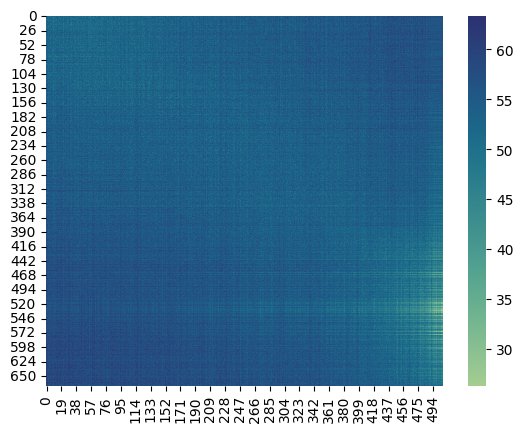

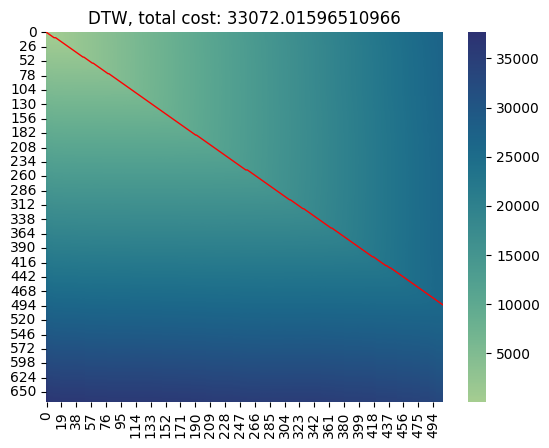

In [24]:
dtw_resultcc = run_dtw(sortd1lC.X.toarray(), sortd2lC.X.toarray())

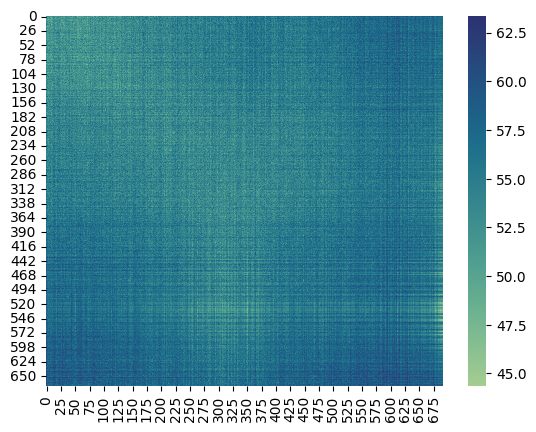

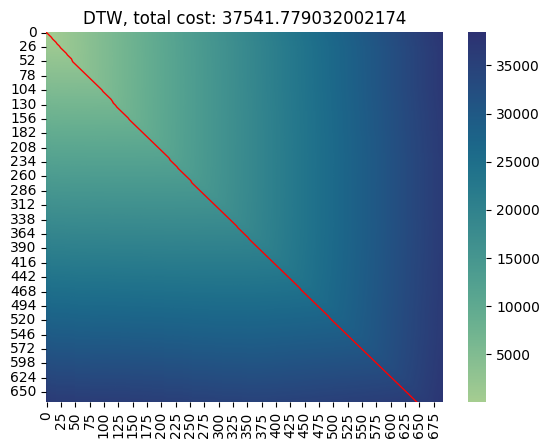

In [25]:
dtw_resultcd = run_dtw(sortd1lC.X.toarray(), sortd2lD.X.toarray())

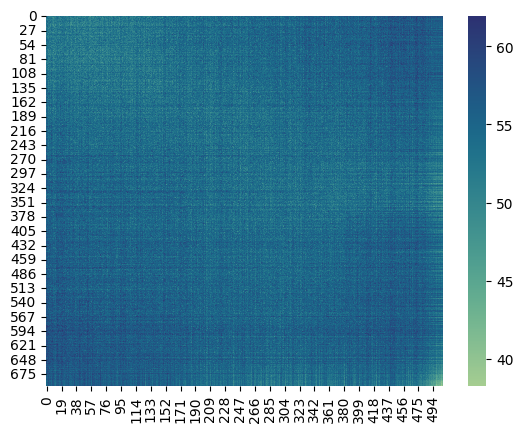

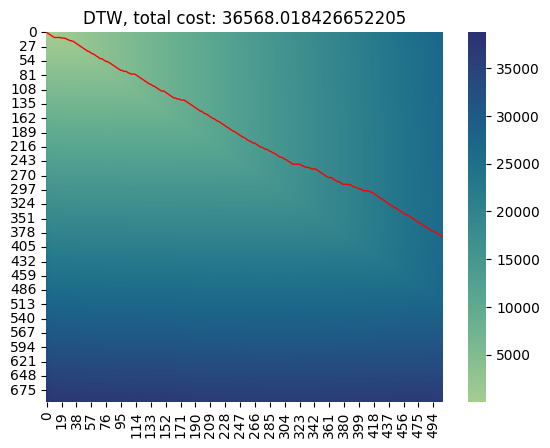

In [26]:
dtw_resultdc = run_dtw(sortd1lD.X.toarray(), sortd2lC.X.toarray())

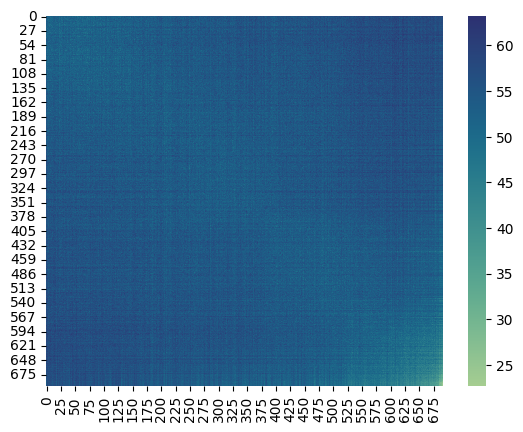

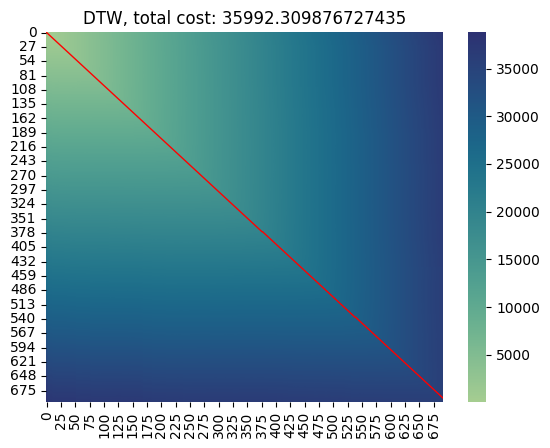

In [27]:
dtw_resultdd = run_dtw(sortd1lD.X.toarray(), sortd2lD.X.toarray())

In [28]:
dtw_resultcc, dtw_resultdd

({'total distance': np.float64(33072.01596510966),
  'cost': array([[52.48719078, 53.98492507, 52.82459826, ..., 57.71867882,
          58.53413254, 57.70977958],
         [50.40143593, 54.88449805, 50.45483394, ..., 56.34383081,
          57.63243494, 57.50758401],
         [54.32693327, 54.29430328, 50.15077959, ..., 57.05162195,
          58.2439569 , 57.8857189 ],
         ...,
         [60.33189851, 57.93952355, 56.5421904 , ..., 50.69361708,
          49.52789672, 49.35777743],
         [60.72535524, 58.41236228, 58.65159492, ..., 49.77199155,
          49.08028603, 48.26801598],
         [60.13512859, 60.5608203 , 57.51804887, ..., 52.76461501,
          51.32632855, 49.65487364]], shape=(668, 507)),
  'distances': array([[    0.        ,            inf,            inf, ...,
                     inf,            inf,            inf],
         [           inf,    52.48719078,   106.47211584, ...,
          27647.46006779, 27705.99420033, 27763.70397991],
         [           inf, 

In [29]:
def warp_pseudotime(cells1, cells2, path1, path2, pseudot1, pseudot2, pseudocells=False):
    changed_pt1 = {}
    changed_pt2 = {}
    for p1, p2 in zip(path1, path2):
        if pseudocells:
            pt1 = pseudot1[p1]
            pt2 = pseudot2[p2]
            # eeek iffy if a multiple pseudocells have the same pseudotime
            changed_pt1 = add_to_dict(changed_pt1, pt1, pt2)
            changed_pt2 = add_to_dict(changed_pt2, pt2, pt1)
        else:
            pt1 = pseudot1.iloc[p1]
            pt2 = pseudot2.iloc[p2]

            changed_pt1 = add_to_dict(changed_pt1, cells1.obs.iloc[p1].name, pt2)
            changed_pt2 = add_to_dict(changed_pt2, cells2.obs.iloc[p2].name, pt1)

    index1 = list(changed_pt1.keys())
    index2 = list(changed_pt2.keys())
    cpt1 = [sum(x) / len(x) for x in changed_pt1.values()]
    cpt2 = [sum(x) / len(x) for x in changed_pt2.values()]

    return index1, cpt1, index2, cpt2


def add_to_dict(d, key, value):
    if key in d:
        d[key].append(value)
        # nr, cur_avg = d[key]
        # cur_avg_update = (cur_avg + value) / (nr + 1)
        # d[key] = (nr+1, cur_avg_update)
    else:
        d[key] = [value]
    return d


# add warped pseudotime to lineage
def add_warped_pseudotime(lineage, new_index, warped_pt, label, pseudocells=False):
    if pseudocells:
        # TODO sort or sth? Or keep the pseudotime as a pandas series/dataframe in .uns?
        lineage.uns[label + "_warped_pseudotime"] = pd.Series(warped_pt, index=new_index)
    else:
        # lineage.obs.iloc[new_index, label + "_warped_pseudotime"] = warped_pt
        lineage.obs[f"{label}_warped_pseudotime"] = pd.NA
        lineage.obs.update(pd.DataFrame({f"{label}_warped_pseudotime": warped_pt}, index=new_index))
        lineage.obs[f"{label}_warped_pseudotime"] = pd.to_numeric(lineage.obs[f"{label}_warped_pseudotime"])

    return lineage

In [30]:
# for each cell
# find which cell it corresponds to according to the path
# find what the pseudotime of those corresponding cells is
# average the pseudotimes of the corresponding cells
# assign this to the original cell

cells1 = sortd1lC
cells2 = sortd2lC

path1 = dtw_resultcc["path"][0]
path2 = dtw_resultcc["path"][1]

from collections import defaultdict
corresponding_cells = defaultdict(list)
corr1 = defaultdict(list)
corr2 = defaultdict(list)

for index1, index2 in zip(path1[1:], path2[1:]): # index is cell in cells2, value is cell in cells1
    corr1[index1].append(cells2.obs.pseudotime.iloc[index2 - 1])
    corr2[index2].append(cells1.obs.pseudotime.iloc[index1 - 1])

for key, value in corr1.items():
    corr1[key] = sum(value) / len(value)
for key, value in corr2.items():
    corr2[key] = sum(value) / len(value)

cells1.obs["warped_pseudotime"] = list(corr1.values())
cells2.obs["warped_pseudotime"] = list(corr2.values())


/tmp/ipykernel_22793/3309355697.py:27: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  cells1.obs["warped_pseudotime"] = list(corr1.values())
/tmp/ipykernel_22793/3309355697.py:28: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  cells2.obs["warped_pseudotime"] = list(corr2.values())


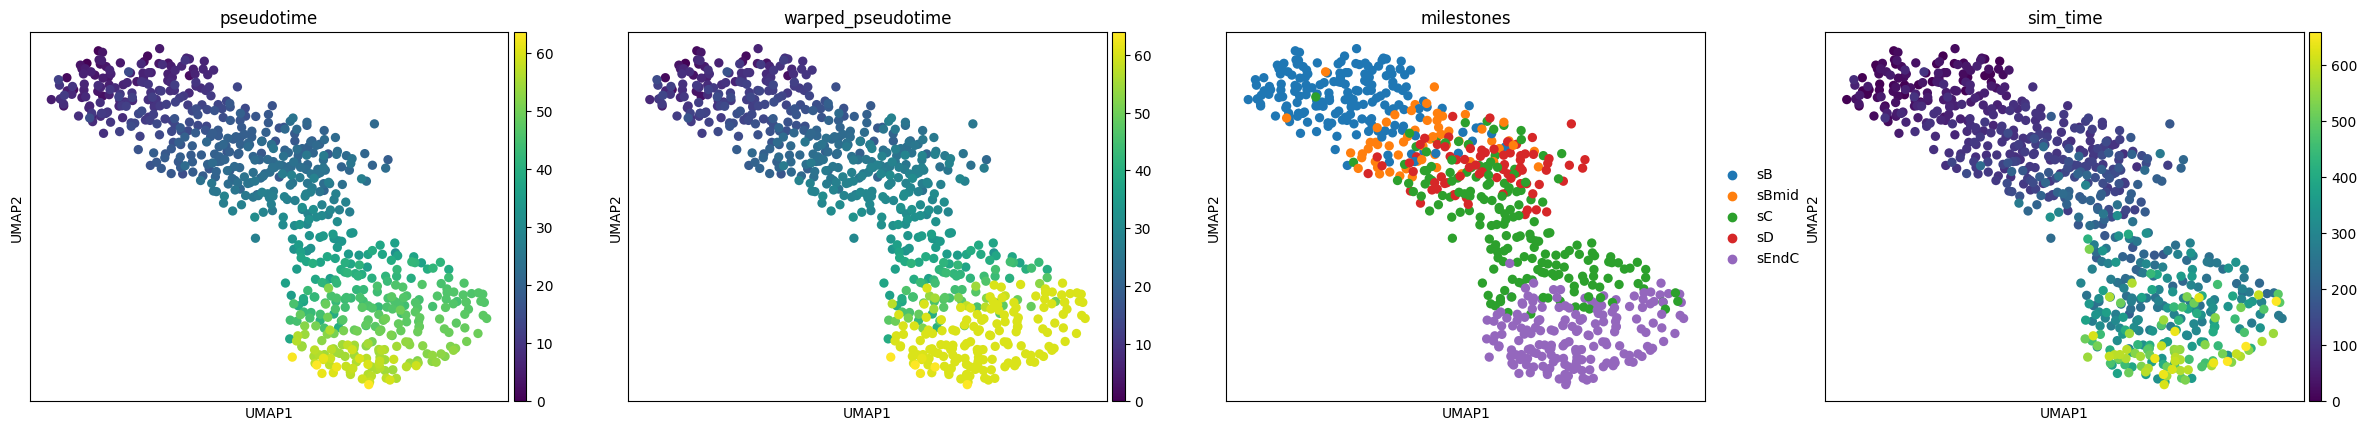

In [31]:
sc.pl.umap(cells1, color=["pseudotime", "warped_pseudotime", "milestones", "sim_time"])

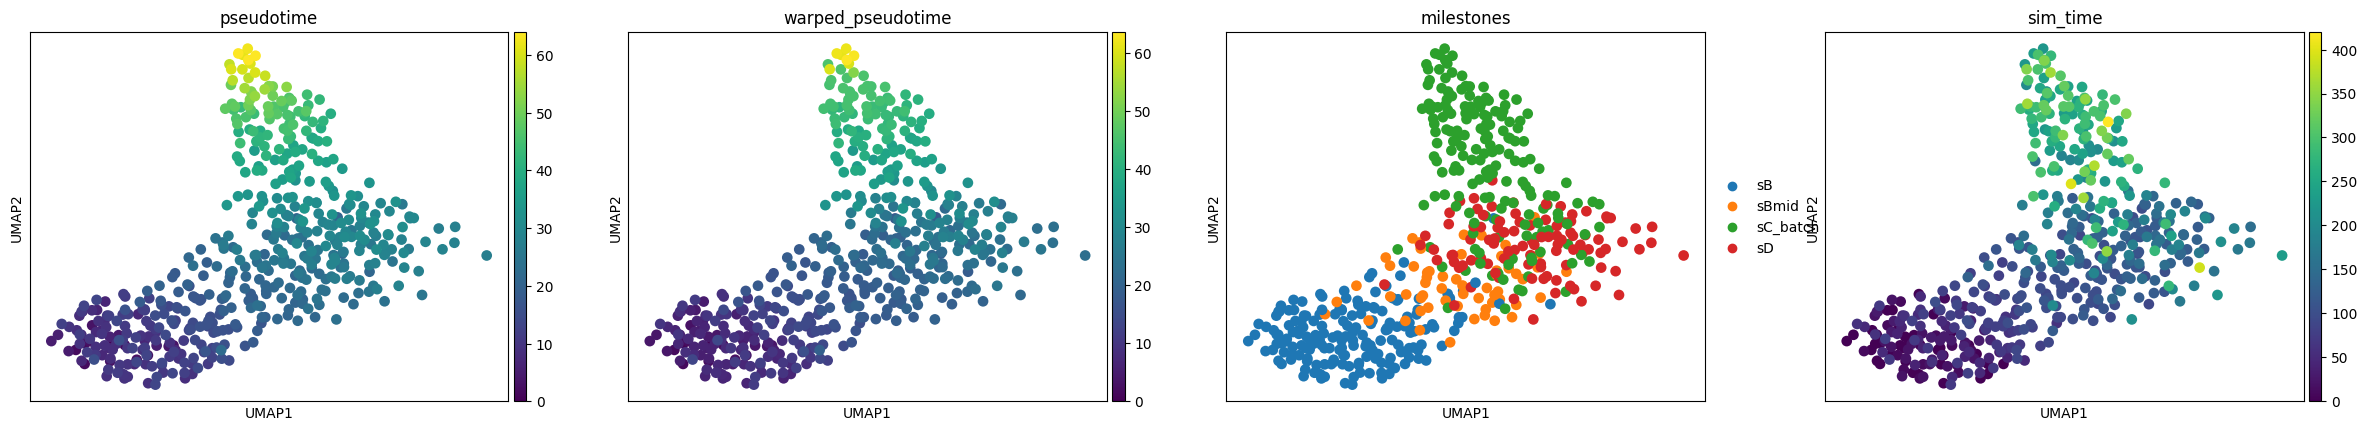

In [32]:
sc.pl.umap(cells2, color=["pseudotime", "warped_pseudotime", "milestones", "sim_time"])

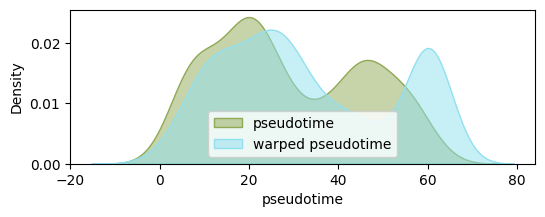

In [33]:
with plt.rc_context(rc={"figure.figsize": (6, 2)}):
    sns.kdeplot(cells1.obs["pseudotime"], label="pseudotime", fill = True, alpha=0.5, color="#90a955")
    sns.kdeplot(cells1.obs["warped_pseudotime"], label="warped pseudotime", fill = True, alpha=0.5, color="#90e0ef")
    plt.legend()

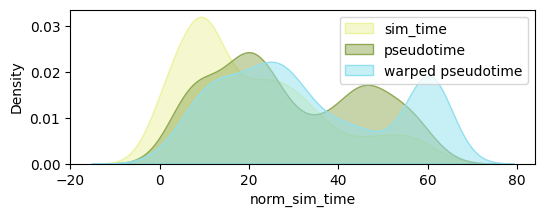

In [34]:
cells1.obs["norm_sim_time"] = (cells1.obs["sim_time"] - min(cells1.obs["sim_time"])) / (max(cells1.obs["sim_time"]) - min(cells1.obs["sim_time"])) * max(cells1.obs["pseudotime"])

with plt.rc_context(rc={"figure.figsize": (6, 2)}):
    sns.kdeplot(cells1.obs["norm_sim_time"], label="sim_time", fill = True, alpha=0.5, color="#ecf39e")
    sns.kdeplot(cells1.obs["pseudotime"], label="pseudotime", fill = True, alpha=0.5, color="#90a955")
    sns.kdeplot(cells1.obs["warped_pseudotime"], label="warped pseudotime", fill = True, alpha=0.5, color="#90e0ef")
    
    plt.legend()

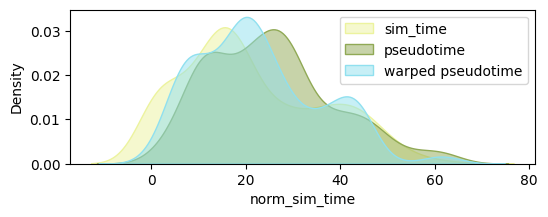

In [35]:
cells2.obs["norm_sim_time"] = (cells2.obs["sim_time"] - min(cells2.obs["sim_time"])) / (max(cells2.obs["sim_time"]) - min(cells2.obs["sim_time"])) * max(cells2.obs["pseudotime"])

with plt.rc_context(rc={"figure.figsize": (6, 2)}):
    sns.kdeplot(cells2.obs["norm_sim_time"], label="sim_time", fill = True, alpha=0.5, color="#ecf39e")
    sns.kdeplot(cells2.obs["pseudotime"], label="pseudotime", fill = True, alpha=0.5, color="#90a955")
    sns.kdeplot(cells2.obs["warped_pseudotime"], label="warped pseudotime", fill = True, alpha=0.5, color="#90e0ef")

    plt.legend()

# Metrics

In [36]:
# dynchro preserves pseudotime
before_pseudotime = pd.concat([norm(cells1.obs["pseudotime"]), norm(cells2.obs["pseudotime"])])
after_pseudotime = pd.concat([norm(cells1.obs["warped_pseudotime"]), norm(cells2.obs["warped_pseudotime"])])

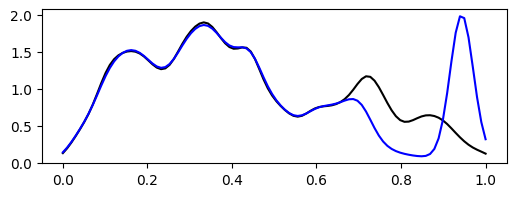

In [37]:
beforex, beforey, beforekde = get_kde_eval(before_pseudotime, bandwith=0.1)
afterx, aftery, afterkde = get_kde_eval(after_pseudotime, bandwith=0.1)

fig = plt.figure(figsize=(6, 2))
ax = fig.add_subplot(111)
ax.plot(beforex, beforey, label="before", color="black")
ax.plot(afterx, aftery, label="after", color="blue")

In [51]:
m = scipy.stats.wasserstein_distance(beforex, afterx, beforey, aftery)
print(f"Wasserstein distance control vs premature stop: {m}")

Wasserstein distance control vs premature stop: 0.016234765010551915


In [39]:
before_c1 = norm(cells1.obs["pseudotime"])
before_c2 = norm(cells2.obs["pseudotime"])
after_c1 = norm(cells1.obs["warped_pseudotime"])
after_c2 = norm(cells2.obs["warped_pseudotime"])

In [40]:
before_c1_x, before_c1_y, before_c1_kde = get_kde_eval(before_c1, bandwith=0.1)
before_c2_x, before_c2_y, before_c2_kde = get_kde_eval(before_c2, bandwith=0.1)
after_c1_x, after_c1_y, after_c1_kde = get_kde_eval(after_c1, bandwith=0.1)
after_c2_x, after_c2_y, after_c2_kde = get_kde_eval(after_c2, bandwith=0.1)

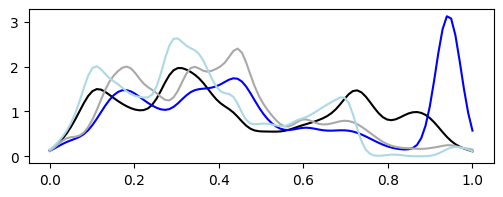

In [41]:
fig = plt.figure(figsize=(6, 2))
ax = fig.add_subplot(111)
ax.plot(before_c1_x, before_c1_y, label="before c1", color="black")
ax.plot(after_c1_x, after_c1_y, label="after c1", color="blue")
ax.plot(before_c2_x, before_c2_y, label="before c2", color="darkgrey")
ax.plot(after_c2_x, after_c2_y, label="after c2", color="lightblue")

In [42]:
np.save("data/before_c1_x", before_c1_x)
np.save("data/before_c1_y", before_c1_y)
np.save("data/before_c2_x", before_c2_x)
np.save("data/before_c2_y", before_c2_y)
np.save("data/before_pseudotime_x", beforex)
np.save("data/before_pseudotime_y", beforey)
np.save("data/before_pseudotime", before_pseudotime)


In [43]:
# cells 1 is to c
# cells 2 is to d
gt1_simtime = norm(cells1.obs["sim_time"])
gt2_simtime = norm(cells2.obs["sim_time"])
gt1_pseudotime = norm(cells1.obs["pseudotime"])
gt2_pseudotime = norm(cells2.obs["pseudotime"])
gt1_warped_pseudotime = norm(cells1.obs["warped_pseudotime"])
gt2_warped_pseudotime = norm(cells2.obs["warped_pseudotime"])

In [44]:
import scipy.stats

bandwidth = 0.1

# kde from gt1_simtime and gt1_warped_pseudotime
kde_gt1_simtime = scipy.stats.gaussian_kde(gt1_simtime, bw_method=bandwidth)
kde_gt1_pseudotime = scipy.stats.gaussian_kde(gt1_pseudotime, bw_method=bandwidth)

# interpolation points
x_eval = np.linspace(0, 1, 100)
# evaluate kdes
kde_gt1_simtime_eval = kde_gt1_simtime(x_eval)
kde_gt1_pseudotime_eval = kde_gt1_pseudotime(x_eval)

Calculate the differences between the distributions

In [47]:
gt1_simtime

cell952    0.030485
cell530    0.000000
cell600    0.000000
cell79     0.000000
cell685    0.000000
             ...   
cell395    0.576933
cell737    0.592112
cell543    0.850157
cell469    0.941105
cell730    0.576933
Name: sim_time, Length: 668, dtype: float64

In [49]:
# uvalues, vvalues = np.linspace(0, 1, 100), np.linspace(0, 1, 100)
# uweights, vweights are the evaluations of the kde values on the interpolation points

m = scipy.stats.wasserstein_distance(x_eval, x_eval, kde_gt1_simtime_eval, kde_gt1_pseudotime_eval)
print(f"Wasserstein distance between gt1_simtime and gt1_warped_pseudotime: {m}")

Wasserstein distance between gt1_simtime and gt1_warped_pseudotime: 0.12437369573824174


In [45]:
cells2.obs.milestones

cell700          sB
cell989          sB
cell393          sB
cell324          sB
cell847          sB
             ...   
cell952    sC_batch
cell351    sC_batch
cell797    sC_batch
cell603    sC_batch
cell942    sC_batch
Name: milestones, Length: 507, dtype: category
Categories (4, object): ['sB', 'sBmid', 'sC_batch', 'sD']

In [ ]:
def get_milestone_normalised(cells1, cells2, milestone1, milestone2, maxv, time = "pseudotime"):
    milestone_cells = pd.concat([cells1[cells1.obs["milestones"] == milestone1].obs[time], cells2[cells2.obs["milestones"] == milestone2].obs[time]])
    localmax = max(milestone_cells) / maxv
    print(maxv, localmax, max(milestone_cells))
    return pd.concat([norm(milestone_cells, max_value=localmax)])
    

In [55]:
maxall = max(cells1.obs["pseudotime"].max(), cells2.obs["pseudotime"].max())
mbcells = get_milestone_normalised(cells1, cells2, "sB", "sB", maxall)
mccells = get_milestone_normalised(cells1, cells2, "sC", "sC_batch", maxall)
mdcells = get_milestone_normalised(cells1, cells2, "sD", "sD", maxall)
mendccells = get_milestone_normalised(cells1, cells2, "sEndC", "sEndC", maxall)
mbmidcells = get_milestone_normalised(cells1, cells2, "sBmid", "sBmid", maxall)

63.97165927516036 0.3503812447950897 22.414469608438033
63.97165927516036 1.0 63.97165927516036
63.97165927516036 0.5177519451966153 33.12145102716937
63.97165927516036 0.9951497200992941 63.66137882196325
63.97165927516036 0.3929129271236364 25.13529189875918


In [56]:
max_warped = max(cells1.obs["warped_pseudotime"].max(), cells2.obs["warped_pseudotime"].max())
mbcells_warped = get_milestone_normalised(cells1, cells2, "sB", "sB", max_warped, time = "warped_pseudotime")
mccells_warped = get_milestone_normalised(cells1, cells2, "sC", "sC_batch", max_warped, time = "warped_pseudotime")
mdcells_warped = get_milestone_normalised(cells1, cells2, "sD", "sD", max_warped, time = "warped_pseudotime")
mendccells_warped = get_milestone_normalised(cells1, cells2, "sEndC", "sEndC", max_warped, time = "warped_pseudotime")
mbmidcells_warped = get_milestone_normalised(cells1, cells2, "sBmid", "sBmid", max_warped, time = "warped_pseudotime")

63.97165927516036 0.3720879581028783 23.803084076147474
63.97165927516036 0.9949163720064498 63.6464511572753
63.97165927516036 0.4952241574935181 31.680311068003693
63.97165927516036 1.0 63.97165927516036
63.97165927516036 0.41209818080772054 26.36260441054493


In [48]:
# # select cells from milestone sA
# milestone_b_cells = pd.concat([norm(cells1[cells1.obs["milestones"] == "sB"].obs.pseudotime, max_value = max(cells1[cells1.obs["milestones"] == "sB"].obs.pseudotime)), norm(cells2[cells2.obs["milestones"] == "sB"].obs.pseudotime, max_value = max(cells2[cells2.obs["milestones"] == "sB"].obs.pseudotime))])
# # milestone_mid_cells = pd.concat([norm(cells1[cells1.obs["milestones"] == "sBmid"].obs.pseudotime, max_value = max(cells1[cells1.obs["milestones"] == "sBmid"].obs.pseudotime)), norm(cells2[cells2.obs["milestones"] == "sBmid"].obs.pseudotime, max_value = max(cells2[cells2.obs["milestones"] == "sBmid"].obs.pseudotime))])
# milestone_c_cells = pd.concat([norm(cells1[cells1.obs["milestones"] == "sC"].obs.pseudotime, max_value = max(cells1[cells1.obs["milestones"] == "sC"].obs.pseudotime)), norm(cells2[cells2.obs["milestones"] == "sC_batch"].obs.pseudotime, max_value= max(cells2[cells2.obs["milestones"] == "sC_batch"].obs.pseudotime))])
# milestone_d_cells = pd.concat([norm(cells1[cells1.obs["milestones"] == "sD"].obs.pseudotime, max_value = max(cells1[cells1.obs["milestones"] == "sD"].obs.pseudotime)), norm(cells2[cells2.obs["milestones"] == "sD"].obs.pseudotime, max_value= max(cells2[cells2.obs["milestones"] == "sD"].obs.pseudotime))])
# milestone_endc_cells = norm(cells1[cells1.obs["milestones"] == "sEndC"].obs.pseudotime, max_value= max(cells1[cells1.obs["milestones"] == "sEndC"].obs.pseudotime))
# lineagec_cells = pd.concat([milestone_c_cells, milestone_endc_cells])

In [49]:
# max(cells1[cells1.obs["milestones"] == "sB"].obs.pseudotime)

In [50]:
xb, yb, _ = get_kde_eval(mbcells, bandwith=0.1)
xm, ym, _ = get_kde_eval(mbmidcells, bandwith=0.1)
xc, yc, _ = get_kde_eval(mccells, bandwith=0.1)
xd, yd, _ = get_kde_eval(mdcells, bandwith=0.1)
xendc, yendc, _ = get_kde_eval(mendccells, bandwith=0.1)

In [57]:
xbw, ybw, _ = get_kde_eval(mbcells_warped, bandwith=0.1)
xmw, ymw, _ = get_kde_eval(mbmidcells_warped, bandwith=0.1)
xcw, ycw, _ = get_kde_eval(mccells_warped, bandwith=0.1)
xdw, ydw, _ = get_kde_eval(mdcells_warped, bandwith=0.1)
xendcw, yendcw, _ = get_kde_eval(mendccells_warped, bandwith=0.1)

In [51]:
max(mbcells), max(xb)

(0.3503812447950897, np.float64(1.0))

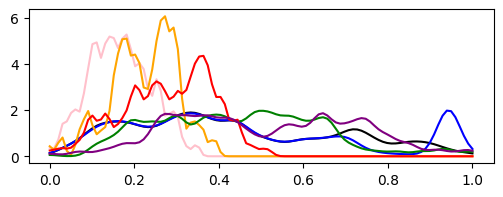

In [52]:
fig = plt.figure(figsize=(6, 2))
ax = fig.add_subplot(111)
ax.plot(beforex, beforey, label="before", color="black")
ax.plot(afterx, aftery, label="after", color="blue")
ax.plot(xb, yb, label="milestone B", color="pink")
ax.plot(xm, ym, label="milestone Bmid", color="orange")
ax.plot(xc, yc, label="milestone C", color="green")
ax.plot(xd, yd, label="milestone D", color="red")
ax.plot(xendc, yendc, label="milestone EndC", color="purple")

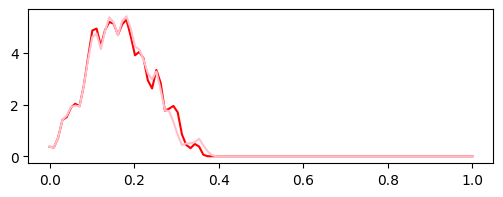

In [58]:
fig = plt.figure(figsize=(6, 2))
ax = fig.add_subplot(111)
ax.plot(xb, yb, label="milestone B", color="red")
ax.plot(xbw, ybw, label="milestone B warped", color="pink")

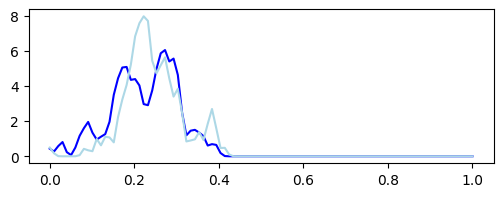

In [60]:
fig = plt.figure(figsize=(6, 2))
ax = fig.add_subplot(111)
ax.plot(xm, ym, label="milestone Bmid", color="blue")
ax.plot(xmw, ymw, label="milestone Bmid warped", color="lightblue")

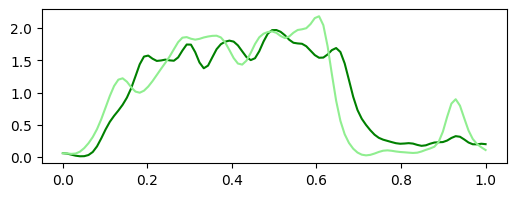

In [59]:
fig = plt.figure(figsize=(6, 2))
ax = fig.add_subplot(111)
ax.plot(xc, yc, label="milestone C", color="green")
ax.plot(xcw, ycw, label="milestone C warped", color="lightgreen")

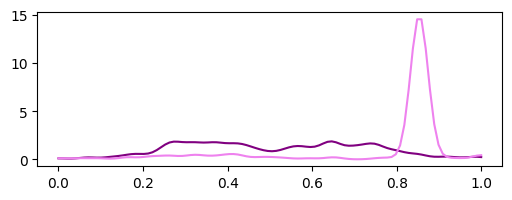

In [61]:
fig = plt.figure(figsize=(6, 2))
ax = fig.add_subplot(111)
ax.plot(xendc, yendc, label="milestone EndC", color="purple")
ax.plot(xendcw, yendcw, label="milestone EndC warped", color="violet")

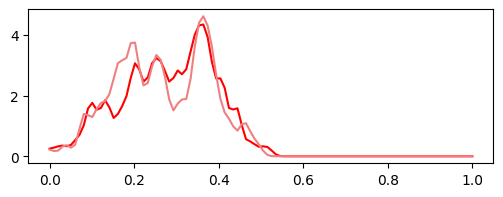

In [62]:
fig = plt.figure(figsize=(6, 2))
ax = fig.add_subplot(111)
ax.plot(xd, yd, label="milestone D", color="red")
ax.plot(xdw, ydw, label="milestone D warped", color="lightcoral")